For some actions, you may want to require human approval before running to ensure that everything is running as intended.

In [481]:
from typing import Annotated
import operator,json
from typing import TypedDict, Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph,END,START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
import os
from dotenv import load_dotenv
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI

from langchain_groq import ChatGroq
load_dotenv()

llm=ChatGroq(model_name="Gemma2-9b-It")


# gemini_api_key = os.getenv("GEMINI_API_KEY")
# embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001",google_api_key=gemini_api_key)
# llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash",api_key=gemini_api_key)

In [482]:
@tool
def multiply(first_number:int, second_number:int)->int:
    """multiply two integer number"""
    return first_number * second_number

In [483]:
@tool
def search(query:str):
    """perform the web search on the user query"""
    tavily=TavilySearchResults()
    result=tavily.invoke(query)
    return result

In [484]:
search("who is a Virat?")

[{'title': 'Virat Kohli - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/Virat_Kohli',
  'content': 'Virat Kohli (Hindi pronunciation: [ʋɪˈɾɑːʈ ˈkoːɦli] ⓘ; born 5 November 1988) is an Indian international cricketer who plays Test and ODI cricket for the Indian national team. A former captain in all formats of the game, Kohli retired from the T20I format following India\'s win at the 2024 T20 World Cup. He\'s a right-handed batsman and an occasional unorthodox right arm medium pace bowler. Kohli holds the highest IPL run-scorer record, ranks third in T20I, third in ODI, and stands the [...] ^ Sharma, Aabhas (8 November 2013). "Why Virat Kohli is who he is". Business Standard. Archived from the original on 23 April 2015. Retrieved 1 June 2015.\n^ Doshi, Anjali; Das, Rahul (21 June 2014). "The Rise and Rise of Virat Kohli". Verve Magazine. Archived from the original on 4 April 2015. Retrieved 1 June 2015.\n^ Jones, Dean (17 March 2017). "Virat Kohli, the highly paid head of the India

In [485]:
tools = [search,multiply]

In [486]:
model_with_tools = llm.bind_tools(tools)

In [487]:
tool_mapping={tool.name: tool for tool in tools}

In [488]:
tool_mapping

{'search': StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x00000297213296C0>),
 'multiply': StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x0000029721329800>)}

In [489]:
response = model_with_tools.invoke("who is virat")

In [490]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0v7g', 'function': {'arguments': '{"query":"who is virat kohli"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 1072, 'total_tokens': 1157, 'completion_time': 0.154545455, 'prompt_time': 0.037693365, 'queue_time': 0.23690463399999998, 'total_time': 0.19223882}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d75d6d1a-49e2-4693-bc61-f9bb1d32a783-0', tool_calls=[{'name': 'search', 'args': {'query': 'who is virat kohli'}, 'id': 'call_0v7g', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1072, 'output_tokens': 85, 'total_tokens': 1157})

In [491]:
tool_details=response.additional_kwargs.get("tool_calls")

In [492]:
tool_details

[{'id': 'call_0v7g',
  'function': {'arguments': '{"query":"who is virat kohli"}',
   'name': 'search'},
  'type': 'function'}]

In [493]:
tool_details[0]["function"]["name"]

'search'

In [494]:
tool_details[0]["function"]["arguments"]

'{"query":"who is virat kohli"}'

In [495]:
json.loads(tool_details[0]["function"]["arguments"])

{'query': 'who is virat kohli'}

In [496]:
tool_mapping[tool_details[0]["function"]["name"]].invoke(json.loads(tool_details[0]["function"]["arguments"]))

[{'title': 'Virat Kohli | Life, Career, Cricket, Awards, & Facts | Britannica',
  'url': 'https://www.britannica.com/biography/Virat-Kohli',
  'content': 'Virat Kohli (born November 5, 1988, Delhi, India) is an Indian international cricketer considered by many as one of the greatest batsmen in the history of the game. Kohli plays for (and previously captained) the Royal Challengers Bangalore (RCB) in the Indian Premier League (IPL). He is also a former captain of the Indian cricket team in all three international formats—Test cricket, one-day internationals (ODIs), and Twenty20 internationals (T20I)—making him one of India’s most successful [...] Kohli was retained in 2018 for $2.1 million but struggled to score as freely as he did in 2016. In 2022 he was retained again for $2 million but relinquished the captaincy, which went to Faf du Plessis. Kohli has since captained on occasion when du Plessis has been injured. Kohli is the highest individual run scorer in the history of the IPL, 

In [497]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],operator.add]
    

In [498]:
def invoke_model(state: AgentState):
    messages = state["messages"]
    question = messages[-1]
    return {"messages":[model_with_tools.invoke(question)]}

In [499]:
def invoke_tool(state: AgentState):
    tool_details = state['messages'][-1].additional_kwargs.get("tool_calls",[])[0]

    if tool_details is None:
        raise Exception("no tool call found")
    
    print(f"selected tool: {tool_details.get("function").get("name")}")

    if tool_details.get("function").get("name") == "search" :
        response = input(prompt=f"[y/n] continue with expensive web search?")

        if response == 'n':
            raise Exception("web search discard")
        
    response = tool_mapping[tool_details["function"]["name"]].invoke(json.loads(tool_details["function"]["arguments"]))
    return {"messages": [response]}

In [500]:
def router(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls",[])
    if len(tool_calls):
        return "tool"
    else:
        return "end"

In [501]:
graph = StateGraph(AgentState)

graph.add_node("ai_assistant",invoke_model)
graph.add_node("tool",invoke_tool)

graph.add_conditional_edges("ai_assistant",router,{"tool":"tool","end":END})

graph.add_edge("tool",END)

graph.set_entry_point("ai_assistant")

app = graph.compile()

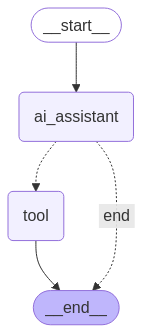

In [502]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [503]:
for s in app.stream({"messages": ["who is upcoming president of USA?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kd14', 'function': {'arguments': '{"query":"upcoming president of USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 1075, 'total_tokens': 1158, 'completion_time': 0.150909091, 'prompt_time': 0.037575525, 'queue_time': 0.24066682, 'total_time': 0.188484616}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-39d17bc6-b5fc-4937-a7ac-169a90e9467c-0', tool_calls=[{'name': 'search', 'args': {'query': 'upcoming president of USA'}, 'id': 'call_kd14', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1075, 'output_tokens': 83, 'total_tokens': 1158})]}
----
selected tool: search
{'messages': [[{'title': '2024 United States presidential election - Wikipedia', 'url': 'https://en.wikipedia.org/wiki/2024_United_States_presidential_election', 'content': "2024 Uni

In [504]:
for s in app.stream({"messages": ["what is multiplication of 23 and 46?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fqtb', 'function': {'arguments': '{"first_number":23,"second_number":46}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 93, 'prompt_tokens': 1080, 'total_tokens': 1173, 'completion_time': 0.169090909, 'prompt_time': 0.037614745, 'queue_time': 0.23472023399999997, 'total_time': 0.206705654}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e19fd407-14ba-411e-b1c2-e02d49151b4c-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 23, 'second_number': 46}, 'id': 'call_fqtb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1080, 'output_tokens': 93, 'total_tokens': 1173})]}
----
selected tool: multiply
{'messages': [1058]}
----


LangGraph supports human-in-the-loop workflows in a number of ways. In this section, we will use LangGraph's interrupt_before functionality to always break the tool node.

In [505]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="Gemma2-9b-It")

In [506]:
tavily = TavilySearchResults()

tools = [tavily,search,multiply]

In [507]:
llm_with_tools = llm.bind_tools(tools)

In [508]:
class AgentState(TypedDict):
    messages: Annotated[list,add_messages]

In [509]:
def ai_assistant(state: AgentState):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [510]:
memory = MemorySaver()

In [511]:
graph = StateGraph(AgentState)

graph.add_node("ai_assistant",ai_assistant)

tool_node = ToolNode(tools=tools)
graph.add_node("tools",tool_node)

graph.add_edge(START,"ai_assistant")
graph.add_conditional_edges(
    "ai_assistant",
    tools_condition,
)
graph.add_edge("tools","ai_assistant")

app2 = graph.compile(checkpointer=memory,interrupt_before=["tools"])

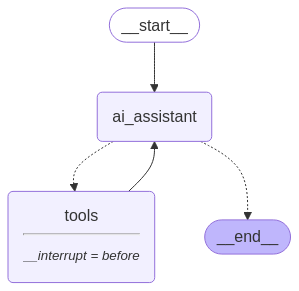

In [512]:
from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))

In [513]:
user_input = "what is current a capital of india?"
config = {"configurable":{"thread_id":"1"}}

In [514]:
events = app2.stream(
    {"messages":[("user",user_input)]},config,stream_mode="values"
)

In [515]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

what is current a capital of india?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_dvh9)
 Call ID: call_dvh9
  Args:
    query: what is the capital of india


In [516]:
snapshot = app2.get_state(config)

In [517]:
snapshot.next

('tools',)

In [518]:
last_message = snapshot.values["messages"][-1]

In [519]:
last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'what is the capital of india'},
  'id': 'call_dvh9',
  'type': 'tool_call'}]

In [520]:
events = app2.stream(None,config, stream_mode="values")

In [521]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_dvh9)
 Call ID: call_dvh9
  Args:
    query: what is the capital of india
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "What is the capital of India? States and union territories explained.", "url": "https://www.usatoday.com/story/news/world/2023/05/24/what-is-the-capital-of-india/70195720007/", "content": "The capital of India is New Delhi, located in the north-central part of the country to the west of the Yamuna River. Calcutta (now Kolkata, the", "score": 0.9018604}, {"title": "Which City became the capital of India for a day, Check here", "url": "https://www.jagranjosh.com/general-knowledge/which-city-became-the-capital-of-india-for-a-day-1731421925-1", "content": "one day capital of India\nIf someone asks you what is the capital of India, you will answer that it is New Delhi

In [522]:
user_input = "what is a weather there?"

config = {"configurable": {"thread_id": "1"}}

In [523]:
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [524]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

what is a weather there?
================================== Ai Message ==================================
Tool Calls:
  search (call_17qs)
 Call ID: call_17qs
  Args:
    query: weather in New Delhi


In [525]:
snapshot = app2.get_state(config)

In [526]:
snapshot.next

('tools',)

In [527]:
last_message=snapshot.values["messages"][-1]

In [528]:
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'weather in New Delhi'},
  'id': 'call_17qs',
  'type': 'tool_call'}]

In [529]:
events = app2.stream(None, config, stream_mode="values")

In [530]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  search (call_17qs)
 Call ID: call_17qs
  Args:
    query: weather in New Delhi
================================= Tool Message =================================
Name: search

[{"title": "Weather in New Delhi", "url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'New Delhi', 'region': 'Delhi', 'country': 'India', 'lat': 28.6, 'lon': 77.2, 'tz_id': 'Asia/Kolkata', 'localtime_epoch': 1744433870, 'localtime': '2025-04-12 10:27'}, 'current': {'last_updated_epoch': 1744433100, 'last_updated': '2025-04-12 10:15', 'temp_c': 27.4, 'temp_f': 81.3, 'is_day': 1, 'condition': {'text': 'Mist', 'icon': '//cdn.weatherapi.com/weather/64x64/day/143.png', 'code': 1030}, 'wind_mph': 6.0, 'wind_kph': 9.7, 'wind_degree': 153, 'wind_dir': 'SSE', 'pressure_mb': 1009.0, 'pressure_in': 29.8, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 51, 'cloud': 0, 'feelslike_c': 25.8, 'feelslike_f': 78.5, 'wi

In [531]:
app2.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='what is current a capital of india?', additional_kwargs={}, response_metadata={}, id='bdc0ef31-59d3-4fa2-9462-db161b48e63d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dvh9', 'function': {'arguments': '{"query":"what is the capital of india"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 1221, 'total_tokens': 1313, 'completion_time': 0.167272727, 'prompt_time': 0.044007303, 'queue_time': 0.23339222599999998, 'total_time': 0.21128003}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0ab90675-0bc8-4e61-bf11-829a7c2e235a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'what is the capital of india'}, 'id': 'call_dvh9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1221, 'output_tokens': 92, 'total_toke

In [532]:
snapshot=app2.get_state(config)

In [533]:
snapshot.next

('tools',)

In [534]:
user_input = "give me the recent news of it?"

config = {"configurable": {"thread_id": "1"}}

In [535]:
events = app2.stream(
    {"messages":[("user",user_input)]},config,stream_mode="values"
)

In [536]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

give me the recent news of it?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_yf1w)
 Call ID: call_yf1w
  Args:
    query: Recent news about New Delhi


In [537]:
snapshot = app2.get_state(config)

In [538]:
current_message = snapshot.values["messages"][-1]

In [539]:
current_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_yf1w)
 Call ID: call_yf1w
  Args:
    query: Recent news about New Delhi


In [540]:
tool_call_id = current_message.tool_calls[0]["id"]

In [541]:
tool_call_id

'call_yf1w'

In [542]:
from langchain_core.messages import AIMessage, ToolMessage

answer = "it is just related to raining which is happing on daily basis"

In [543]:
new_messages = [
    ToolMessage(content=answer, tool_call_id=tool_call_id),
    AIMessage(content=answer)
]

In [544]:
app2.update_state(
    config,
    {"messages": new_messages},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0175ab-66cd-6efd-800c-bd63e1c6ab76'}}

In [545]:
print(app2.get_state(config).values["messages"][-1:])

[AIMessage(content='it is just related to raining which is happing on daily basis', additional_kwargs={}, response_metadata={}, id='d7ac9e62-9fc6-4dae-9cc3-8d8cb1ec97ad')]
